# 5. Modélisation : Deep Learning

## Variables d'environnement

In [1]:
TRAIN_TWEETS_PATH = 'data/train_tweets.parquet'
TEST_TWEETS_PATH = 'data/test_tweets.parquet'
VALIDATION_TWEETS_PATH = 'data/validation_tweets.parquet'

VOCAB_SIZE = 20000
MAX_LEN = 30

## Imports des dépendances

In [2]:
import os
import zipfile
import pandas as pd
import numpy as np
import time
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense, Dropout, Input, LSTM, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, Callback
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.backend import clear_session
from plot_keras_history import show_history, plot_history
import requests
from tqdm import tqdm
from gensim.models import Word2Vec
import pickle
import mlflow
import mlflow.tensorflow

I0000 00:00:1768734746.270943     810 port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
I0000 00:00:1768734746.810708     810 cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
I0000 00:00:1768734748.355771     810 port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


## Configuration des dépendances

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

mlflow.set_experiment("Sentiments_Tweets")
mlflow.tensorflow.autolog(disable=True)

W0000 00:00:1768734752.105435     810 gpu_device.cc:2459] TensorFlow was not built with CUDA kernel binaries compatible with compute capability 12.0a. CUDA kernels will be jit-compiled from PTX, which could take 30 minutes or longer.


Num GPUs Available:  1


2026/01/18 12:12:32 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2026/01/18 12:12:32 INFO mlflow.store.db.utils: Updating database tables
2026/01/18 12:12:32 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2026/01/18 12:12:32 INFO alembic.runtime.migration: Will assume non-transactional DDL.
2026/01/18 12:12:32 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2026/01/18 12:12:32 INFO alembic.runtime.migration: Will assume non-transactional DDL.


In [4]:
class MLflowCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        """Enregistre les métriques à la fin de chaque epoch"""
        if logs is None:
            return

        # Petit délai pour éviter les timestamps identiques
        time.sleep(0.001)

        # Enregistrer toutes les métriques
        for metric_name, metric_value in logs.items():
            mlflow.log_metric(metric_name, metric_value, step=epoch)

        # Enregistrer aussi le learning rate actuel si disponible
        if hasattr(self.model.optimizer, 'lr'):
            current_lr = float(tf.keras.backend.get_value(self.model.optimizer.lr))
            mlflow.log_metric("learning_rate", current_lr, step=epoch)

## Imports des jeux de données

In [5]:
train_df = pd.read_parquet(TRAIN_TWEETS_PATH).fillna('')
test_df = pd.read_parquet(TEST_TWEETS_PATH).fillna('')
validation_df = pd.read_parquet(VALIDATION_TWEETS_PATH).fillna('')

In [6]:
# --- JEU DE DONNÉES : LEMMATIZED ---

# Train
X_train_lemmatized = train_df['text_lemmatized']
y_train_lemmatized = train_df['target']

# Validation
X_val_lemmatized = validation_df['text_lemmatized']
y_val_lemmatized = validation_df['target']

# Test
X_test_lemmatized = test_df['text_lemmatized']
y_test_lemmatized = test_df['target']

## Tokenisation et préparation des données

In [7]:
def download_glove_embedding(url="https://nlp.stanford.edu/data/glove.6B.zip", output_path="embeddings/glove.6B"):
    zip_path = f"{output_path}.zip"
    output_dir = os.path.dirname(output_path)

    glove_files_exist = any(
        os.path.exists(os.path.join(output_dir, f"glove.6B.{dim}d.txt"))
        for dim in [50, 100, 200, 300]
    )

    if not glove_files_exist:
        os.makedirs(output_dir, exist_ok=True)

        if not os.path.exists(zip_path):
            print(f"Téléchargement de l'embedding Glove (via {url})...")
            response = requests.get(url)
            response.raise_for_status()

            with open(zip_path, 'wb') as f:
                f.write(response.content)
            print(f"Téléchargement terminé. Fichier enregistré à {zip_path}")
        else:
            print(f"Fichier {zip_path} déjà présent, extraction...")

        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            print("Extraction du fichier zip...")
            zip_ref.extractall(output_dir)  # Extrait directement dans le dossier 'embeddings/'
            print("Extraction terminée.")
    else:
        print(f"Les fichiers d'embedding Glove sont déjà présents dans {output_dir}")

In [8]:
def create_embedding_matrix(word_index, embedding_source, embedding_dim, max_vocab_size):
    """
    Crée une matrice d'embedding compatible Keras.
    Accepte soit un dictionnaire (GloVe), soit un modèle Gensim (Word2Vec).
    """
    num_words = min(max_vocab_size, len(word_index) + 1)
    embedding_matrix = np.zeros((num_words, embedding_dim))

    found_words = 0

    print(f"Création de la matrice ({embedding_dim}d) pour les top {num_words} mots...")

    for word, i in tqdm(word_index.items(), total=len(word_index), desc="Remplissage Matrice"):

        if i < num_words:
            embedding_vector = None

            # --- DÉTECTION DU TYPE DE SOURCE ---

            # CAS 1 : C'est un modèle GENSIM (Word2Vec)
            # On vérifie s'il a l'attribut 'wv' (KeyedVectors)
            if hasattr(embedding_source, 'wv'):
                if word in embedding_source.wv:
                    embedding_vector = embedding_source.wv[word]

            # CAS 2 : C'est un DICTIONNAIRE (GloVe / FastText chargé à la main)
            elif isinstance(embedding_source, dict):
                embedding_vector = embedding_source.get(word)

            # -----------------------------------

            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
                found_words += 1

    percentage = (found_words / num_words) * 100
    print(f"Succès : {found_words} mots trouvés sur {num_words} ({percentage:.2f}%)")

    return embedding_matrix

In [9]:
def load_embedding(filename):
    embeddings_index = {}

    with open(filename, encoding='utf-8') as f:
        for line in f:
            values = line.split()

            if len(values) < 2:
                continue

            word = values[0]
            vector = values[1:]

            embeddings_index[word] = np.asarray(vector, dtype='float32')

    print(f"Chargé {len(embeddings_index)} vecteurs depuis {filename}")
    return embeddings_index

In [10]:
def plot_graphs(history, metric, model_name="model"):
    plt.figure(figsize=(8, 6))
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])
    plt.title(f"Évolution de {metric} pour {model_name}")

    filename = f"{model_name}_{metric}.png"
    plt.savefig(filename)
    if mlflow.active_run():
        mlflow.log_artifact(filename, artifact_path="graphs")

    plt.show()
    plt.close()
    os.remove(filename)

In [11]:
def display_roc_auc_graph(model, X_test_pad, y_test, model_name="model"):
    y_pred_proba = model.predict(X_test_pad).ravel()
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Modèle (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Taux de Faux Positifs (False Positive Rate)')
    plt.ylabel('Taux de Vrais Positifs (True Positive Rate)')
    plt.title(f'Courbe ROC - {model_name}')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)

    filename = f"{model_name}_ROC.png"
    plt.savefig(filename)

    if mlflow.active_run():
        mlflow.log_artifact(filename, artifact_path="mes_beaux_graphiques")

    plt.show()
    plt.close()
    os.remove(filename)

In [12]:
def get_callbacks_list(checkpoint_filepath):
    return [
        ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_loss', save_best_only=True, mode='min', verbose=1),
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=0.000001, verbose=1)
    ]

In [13]:
def train_model(model_seq, epochs, batch_size, X_train_pad, y_train, X_val_pad, y_val,
                X_test_pad, y_test, learning_rate=0.0001, model_name="best_model"):
    current_model = f"{model_name}.keras"

    with mlflow.start_run(run_name=model_name):
        # Enregistrer les hyperparamètres
        mlflow.log_param("epochs", epochs)
        mlflow.log_param("batch_size", batch_size)
        mlflow.log_param("learning_rate", learning_rate)
        mlflow.log_param("vocab_size", VOCAB_SIZE)
        mlflow.log_param("max_len", MAX_LEN)

        print(f"🤖 Compilation et Entraînement de {model_name} sous surveillance MLflow... \n")

        model_seq.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
            loss='binary_crossentropy',
            metrics=['accuracy', 'AUC']
        )

        callbacks_list = get_callbacks_list(current_model)
        callbacks_list.append(MLflowCallback())

        # Entraînement
        history = model_seq.fit(
            X_train_pad, y_train.to_numpy(),
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(X_val_pad, y_val.to_numpy()),
            callbacks=callbacks_list,
            verbose=1
        )

        print("Évaluation sur le jeu de test...")
        test_results = model_seq.evaluate(X_test_pad, y_test.to_numpy(), verbose=0)

        # Enregistrer les métriques finales de test
        mlflow.log_metric("test_loss", test_results[0])
        mlflow.log_metric("test_accuracy", test_results[1])
        mlflow.log_metric("test_auc", test_results[2])

        print(f"Sauvegarde du modèle dans le dossier : model_{model_name}...")
        mlflow.tensorflow.log_model(model_seq, artifact_path=f"model_{model_name}",
                                     registered_model_name=model_name)

        print("Sauvegarde et affichage des graphiques...")
        plot_graphs(history, "accuracy", model_name)
        plot_graphs(history, "loss", model_name)
        display_roc_auc_graph(model_seq, X_test_pad, y_test.to_numpy(), model_name)

        print(f"Fin de l'enregistrement MLflow pour {model_name}.")

    return history

# def train_model(model_seq, epochs, batch_size, X_train_pad, y_train, X_val_pad, y_val, X_test_pad, y_test, learning_rate=0.0001, model_name="best_model"):
#     current_model = f"{model_name}.keras"
#
#     with mlflow.start_run(run_name=model_name):
#         mlflow.log_param("epochs", epochs)
#         mlflow.log_param("batch_size", batch_size)
#         mlflow.log_param("learning_rate", learning_rate)
#
#         print(f"🤖 Compilation et Entraînement de {model_name} sous surveillance MLflow... \n")
#
#         model_seq.compile(
#             optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
#             loss='binary_crossentropy',
#             metrics=['accuracy', 'AUC']
#         )
#
#         callbacks_list = get_callbacks_list(current_model)
#
#         history = model_seq.fit(
#             X_train_pad, y_train.to_numpy(),
#             epochs=epochs,
#             batch_size=batch_size,
#             validation_data=(X_val_pad, y_val.to_numpy()),
#             callbacks=callbacks_list,
#             verbose=1
#         )
#
#         print("Évaluation sur le jeu de test...")
#         test_results = model_seq.evaluate(X_test_pad, y_test.to_numpy(), verbose=0)
#
#         final_metrics = {
#             "final_train_loss": history.history['loss'][-1],
#             "final_train_accuracy": history.history['accuracy'][-1],
#             "final_train_auc": history.history['AUC'][-1],
#             "final_val_loss": history.history['val_loss'][-1],
#             "final_val_accuracy": history.history['val_accuracy'][-1],
#             "final_val_auc": history.history['val_AUC'][-1],
#             "test_loss": test_results[0],
#             "test_accuracy": test_results[1],
#             "test_auc": test_results[2]
#         }
#
#         for metric_name, metric_value in final_metrics.items():
#             mlflow.log_metric(metric_name, metric_value)
#
#         print(f"Sauvegarde du modèle dans le dossier : model_{model_name}...")
#         mlflow.tensorflow.log_model(model_seq, artifact_path=f"model_{model_name}", registered_model_name=model_name)
#
#         print("Sauvegarde et affichage des graphiques...")
#         plot_graphs(history, "accuracy", model_name)
#         plot_graphs(history, "loss", model_name)
#         display_roc_auc_graph(model_seq, X_test_pad, y_test.to_numpy(), model_name)
#
#         print(f"Fin de l'enregistrement MLflow pour {model_name}.")
#
#     return history

# def train_model(model_seq, epochs, batch_size, X_train_pad, y_train, X_val_pad, y_val, X_test_pad, y_test, learning_rate=0.0001, model_name="best_model"):
#     current_model = f"{model_name}.keras"
#
#     with mlflow.start_run(run_name=model_name):
#         mlflow.log_param("epochs", epochs)
#         mlflow.log_param("batch_size", batch_size)
#         mlflow.log_param("learning_rate", learning_rate)
#
#         print(f"🤖 Compilation et Entraînement de {model_name} sous surveillance MLflow... \n")
#
#         model_seq.compile(
#             optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
#             loss='binary_crossentropy',
#             metrics=['accuracy', 'AUC']
#         )
#
#         callbacks_list = get_callbacks_list(current_model)
#
#         history = model_seq.fit(
#             X_train_pad, y_train.to_numpy(),
#             epochs=epochs,
#             batch_size=batch_size,
#             validation_data=(X_val_pad, y_val.to_numpy()),
#             callbacks=callbacks_list,
#             verbose=1
#         )
#
#         print("Évaluation sur le jeu de test...")
#         test_results = model_seq.evaluate(X_test_pad, y_test.to_numpy(), verbose=0)
#
#         # mlflow.log_metric("test_loss", test_results[0])
#         # mlflow.log_metric("test_accuracy", test_results[1])
#         # mlflow.log_metric("test_auc", test_results[2])
#
#         print(f"Sauvegarde du modèle dans le dossier : model_{model_name}...")
#         mlflow.tensorflow.log_model(model_seq, artifact_path=f"model_{model_name}", registered_model_name=model_name)
#
#         print("Sauvegarde et affichage des graphiques...")
#         plot_graphs(history, "accuracy", model_name)
#         plot_graphs(history, "loss", model_name)
#         display_roc_auc_graph(model_seq, X_test_pad, y_test.to_numpy(), model_name)
#
#         print(f"Fin de l'enregistrement MLflow pour {model_name}.")
#
#     return history

In [14]:
EMBEDDING_DIM = 32
EPOCHS = 50
BATCH_SIZE = 256

tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train_lemmatized)

with open('data/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

train_sequences = tokenizer.texts_to_sequences(X_train_lemmatized)
val_sequences = tokenizer.texts_to_sequences(X_val_lemmatized)
test_sequences = tokenizer.texts_to_sequences(X_test_lemmatized)

print(f"Exemple tweet original : {X_test_lemmatized.iloc[42]}")
print(f"Exemple tweet transformé : {train_sequences[42]}")

X_train_pad = pad_sequences(train_sequences, maxlen=MAX_LEN, padding='post', truncating='post')
X_val_pad = pad_sequences(val_sequences, maxlen=MAX_LEN, padding='post', truncating='post')
X_test_pad = pad_sequences(test_sequences, maxlen=MAX_LEN, padding='post', truncating='post')

print(f"Forme des données Train pour Keras : {X_train_pad.shape}")

Exemple tweet original : dance party washing car way work even though everyone goin grammys dinner erica bday
Exemple tweet transformé : [725, 58, 1691, 326, 5318, 669, 183, 14076, 270, 18, 14, 391, 102, 54, 301]
Forme des données Train pour Keras : (1120000, 30)


## Embedding maison

W0000 00:00:1767948825.403107    5447 gpu_device.cc:2459] TensorFlow was not built with CUDA kernel binaries compatible with compute capability 12.0a. CUDA kernels will be jit-compiled from PTX, which could take 30 minutes or longer.
W0000 00:00:1767948825.583079    5447 gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was false.
I0000 00:00:1767948825.583395    5447 gpu_device.cc:2043] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13209 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 5070 Ti, pci bus id: 0000:01:00.0, compute capability: 12.0a


🤖 Compilation et Entraînement de model_simple_01 sous surveillance MLflow... 

Epoch 1/50


I0000 00:00:1767948827.370100    5536 cuda_dnn.cc:461] Loaded cuDNN version 91701


4373/4375 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - AUC: 0.7536 - accuracy: 0.6893 - loss: 0.7784
Epoch 1: val_loss improved from None to 0.47591, saving model to model_simple_01.keras
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 93s 21ms/step - AUC: 0.8216 - accuracy: 0.7489 - loss: 0.6158 - val_AUC: 0.8663 - val_accuracy: 0.7838 - val_loss: 0.4759 - learning_rate: 1.0000e-04
Epoch 2/50
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - AUC: 0.8633 - accuracy: 0.7923 - loss: 0.4727
Epoch 2: val_loss improved from 0.47591 to 0.45417, saving model to model_simple_01.keras
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 92s 21ms/step - AUC: 0.8651 - accuracy: 0.7931 - loss: 0.4688 - val_AUC: 0.8729 - val_accuracy: 0.7913 - val_loss: 0.4542 - learning_rate: 1.0000e-04
Epoch 3/50
4371/4375 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - AUC: 0.8712 - accuracy: 0.7974 - loss: 0.4572
Epoch 3: val_loss improved from 0.45417 to 0.44608, saving model to model_simple_01.keras
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 81s 18ms/step - AUC: 0.8722 - accuracy: 0.

2026/01/09 10:19:40 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/01/09 10:19:40 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


Sauvegarde du modèle dans le dossier : model_model_simple_01...


2026/01/09 10:19:45 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2026/01/09 10:19:45 INFO mlflow.store.db.utils: Updating database tables
2026/01/09 10:19:45 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2026/01/09 10:19:45 INFO alembic.runtime.migration: Will assume non-transactional DDL.


Sauvegarde et affichage des graphiques...


Registered model 'model_simple_01' already exists. Creating a new version of this model...
Created version '4' of model 'model_simple_01'.


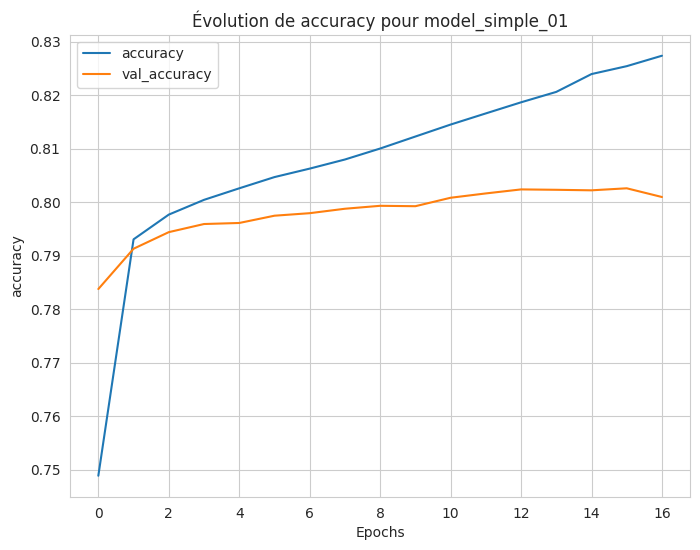

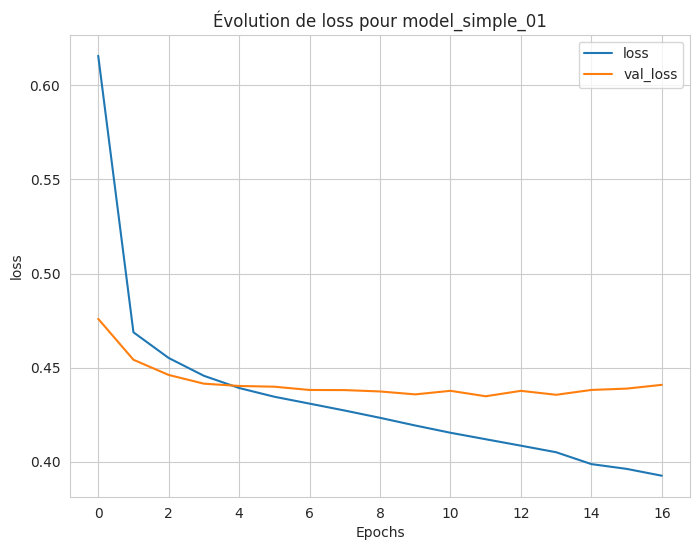

7500/7500 ━━━━━━━━━━━━━━━━━━━━ 38s 5ms/step


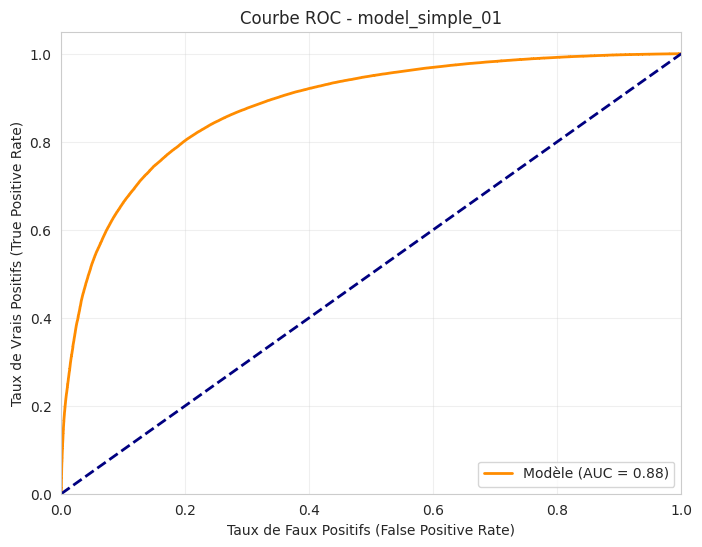

Fin de l'enregistrement MLflow pour model_simple_01.


In [15]:
model_simple_01_seq = Sequential([
    Input(shape=(MAX_LEN,)),
    Embedding(VOCAB_SIZE, EMBEDDING_DIM),
    Bidirectional(LSTM(32, return_sequences=False)),
    Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model_simple_01_results_df = train_model(model_simple_01_seq, EPOCHS, BATCH_SIZE, X_train_pad, y_train_lemmatized, X_val_pad, y_val_lemmatized, X_test_pad, y_test_lemmatized, learning_rate=0.0001, model_name="model_simple_01")

model_simple_01_results_df

## Embedding Glove

In [16]:
EMBEDDING_DIM=300
GLOVE_FILE_PATH = f"embeddings/glove.6B.{EMBEDDING_DIM}d.txt"

download_glove_embedding()
glove_embeddings = load_embedding(GLOVE_FILE_PATH)
embedding_matrix = create_embedding_matrix(tokenizer.word_index, glove_embeddings, EMBEDDING_DIM, VOCAB_SIZE)

Les fichiers d'embedding Glove sont déjà présents dans embeddings
Chargé 400000 vecteurs depuis embeddings/glove.6B.300d.txt
Création de la matrice (300d) pour les top 20000 mots...


Remplissage Matrice: 100%|███████████████████████| 330440/330440 [00:00<00:00, 4325979.03it/s]

Succès : 16661 mots trouvés sur 20000 (83.30%)


🤖 Compilation et Entraînement de model_glove_02 sous surveillance MLflow... 

Epoch 1/50
4371/4375 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - AUC: 0.7682 - accuracy: 0.7048 - loss: 0.7597
Epoch 1: val_loss improved from None to 0.49260, saving model to model_glove_02.keras
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 101s 23ms/step - AUC: 0.8140 - accuracy: 0.7440 - loss: 0.6170 - val_AUC: 0.8504 - val_accuracy: 0.7699 - val_loss: 0.4926 - learning_rate: 1.0000e-04
Epoch 2/50
4372/4375 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - AUC: 0.8473 - accuracy: 0.7747 - loss: 0.4934
Epoch 2: val_loss improved from 0.49260 to 0.47324, saving model to model_glove_02.keras
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 94s 21ms/step - AUC: 0.8495 - accuracy: 0.7763 - loss: 0.4894 - val_AUC: 0.8606 - val_accuracy: 0.7798 - val_loss: 0.4732 - learning_rate: 1.0000e-04
Epoch 3/50
4374/4375 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - AUC: 0.8569 - accuracy: 0.7819 - loss: 0.4776
Epoch 3: val_loss improved from 0.47324 to 0.46505, saving model to model_g

2026/01/09 11:25:38 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/01/09 11:25:38 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


Sauvegarde du modèle dans le dossier : model_model_glove_02...
Sauvegarde et affichage des graphiques...


Successfully registered model 'model_glove_02'.
Created version '1' of model 'model_glove_02'.


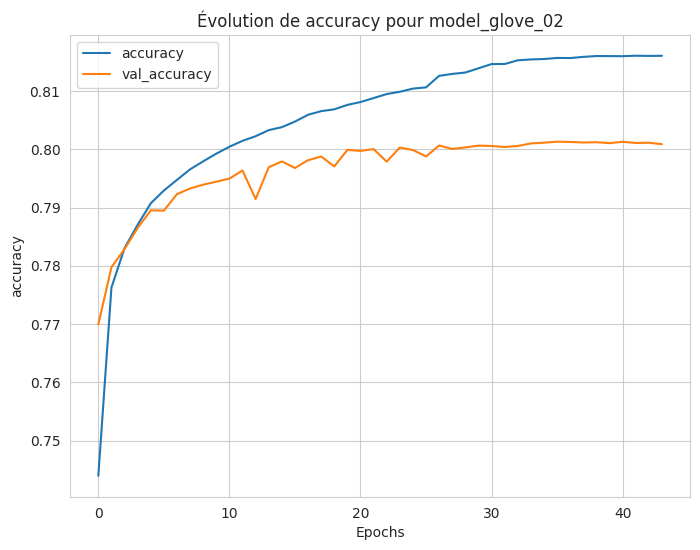

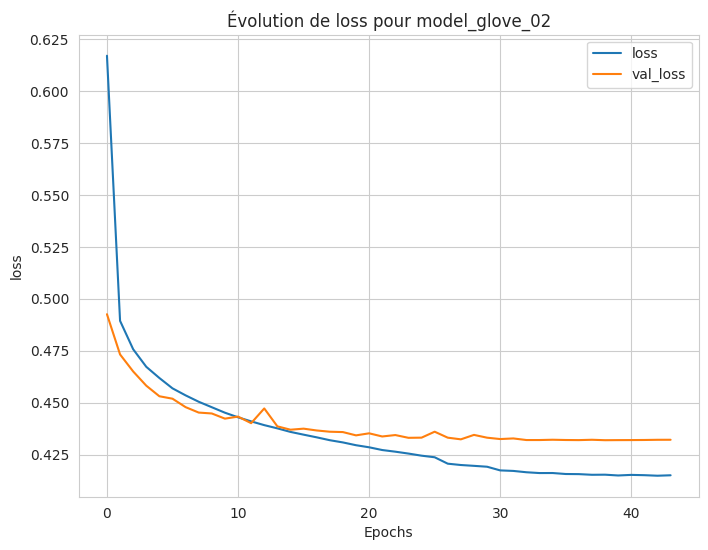

7500/7500 ━━━━━━━━━━━━━━━━━━━━ 41s 5ms/step


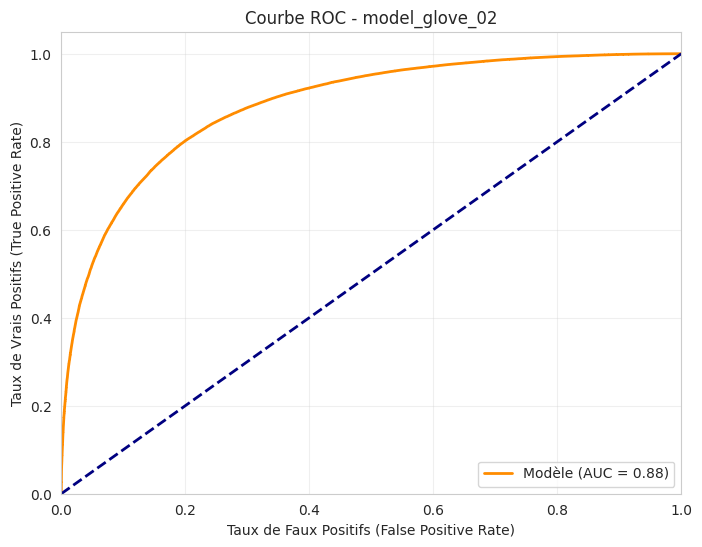

Fin de l'enregistrement MLflow pour model_glove_02.


In [17]:
model_glove_02_seq = Sequential([
    Input(shape=(MAX_LEN,)),
    Embedding(
        VOCAB_SIZE,
        EMBEDDING_DIM,
        weights=[embedding_matrix],
        trainable=False # ON GÈLE LE SAVOIR : Le modèle ne peut pas modifier GloVe
    ),
    Bidirectional(LSTM(32, return_sequences=False)),
    Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model_glove_02_results_df = train_model(model_glove_02_seq, EPOCHS, BATCH_SIZE, X_train_pad, y_train_lemmatized, X_val_pad, y_val_lemmatized, X_test_pad, y_test_lemmatized, learning_rate=0.0001, model_name="model_glove_02")

model_glove_02_results_df

## Embedding Word2Vec

### Entrainement de l'embedding

In [18]:
sentences = []
for row in train_df['tokens_lemmatized']:
    if isinstance(row, np.ndarray):
        # C'est le cas problématique que vous avez : on le convertit en liste
        sentences.append(row.tolist())
    elif isinstance(row, list):
        # Si c'est déjà une liste, on garde
        sentences.append(row)
    # On ignore les NaN ou les floats

In [19]:
EMBEDDING_DIM = 100

print("Entrainement de Word2Vec sur les tweets...")
start_time = time.time()
w2v_model = Word2Vec(sentences=sentences, vector_size=EMBEDDING_DIM, window=5, min_count=5, workers=4)
print(f"Terminé en {(time.time() - start_time):.2f} secondes !")
print(f"Taille du vocabulaire appris : {len(w2v_model.wv)}")

word_to_test = "good"
if word_to_test in w2v_model.wv:
    print(f"\nMots les plus proches de '{word_to_test}':")
    print(w2v_model.wv.most_similar(word_to_test))

Entrainement de Word2Vec sur les tweets...
Terminé en 7.71 secondes !
Taille du vocabulaire appris : 41321

Mots les plus proches de 'good':
[('great', 0.7382266521453857), ('goood', 0.6414202451705933), ('bad', 0.61176598072052), ('rough', 0.5991796851158142), ('tough', 0.5752551555633545), ('gooood', 0.5686250925064087), ('awful', 0.5452737808227539), ('excellent', 0.5407121777534485), ('fantastic', 0.539597749710083), ('goooood', 0.5345345735549927)]


Word2Vec n'apprend pas le sentiment (Positif/Négatif), il apprend le contexte grammatical.
Pour Word2Vec, les mots "bon" et "mauvais" apparaissent exactement au même endroit, entourés des mêmes mots ("Ce", "film", "était"). Pour lui, ils sont interchangeables. Ils appartiennent à la même famille : les adjectifs de jugement.

Word2Vec a fait le travail de regroupement sémantique (il a mis tous les adjectifs ensemble). Le LSTM fera le travail de discrimination.

### Création de la matrice d'embedding

In [20]:
embedding_matrix_w2v = create_embedding_matrix(tokenizer.word_index, w2v_model, EMBEDDING_DIM, VOCAB_SIZE)

Création de la matrice (100d) pour les top 20000 mots...


Remplissage Matrice: 100%|███████████████████████| 330440/330440 [00:00<00:00, 1521078.67it/s]

Succès : 19998 mots trouvés sur 20000 (99.99%)


### Entrainement du modèle

🤖 Compilation et Entraînement de model_w2v_03 sous surveillance MLflow... 

Epoch 1/50
4374/4375 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - AUC: 0.7971 - accuracy: 0.7290 - loss: 0.7261
Epoch 1: val_loss improved from None to 0.46104, saving model to model_w2v_03.keras
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 86s 19ms/step - AUC: 0.8398 - accuracy: 0.7661 - loss: 0.5838 - val_AUC: 0.8698 - val_accuracy: 0.7885 - val_loss: 0.4610 - learning_rate: 1.0000e-04
Epoch 2/50
4373/4375 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - AUC: 0.8683 - accuracy: 0.7922 - loss: 0.4625
Epoch 2: val_loss improved from 0.46104 to 0.44308, saving model to model_w2v_03.keras
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 93s 21ms/step - AUC: 0.8700 - accuracy: 0.7934 - loss: 0.4589 - val_AUC: 0.8788 - val_accuracy: 0.7955 - val_loss: 0.4431 - learning_rate: 1.0000e-04
Epoch 3/50
4372/4375 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - AUC: 0.8781 - accuracy: 0.8008 - loss: 0.4445
Epoch 3: val_loss improved from 0.44308 to 0.43191, saving model to model_w2v_03.k

2026/01/09 11:55:39 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/01/09 11:55:39 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


Sauvegarde du modèle dans le dossier : model_model_w2v_03...
Sauvegarde et affichage des graphiques...


Registered model 'model_w2v_03' already exists. Creating a new version of this model...
Created version '2' of model 'model_w2v_03'.


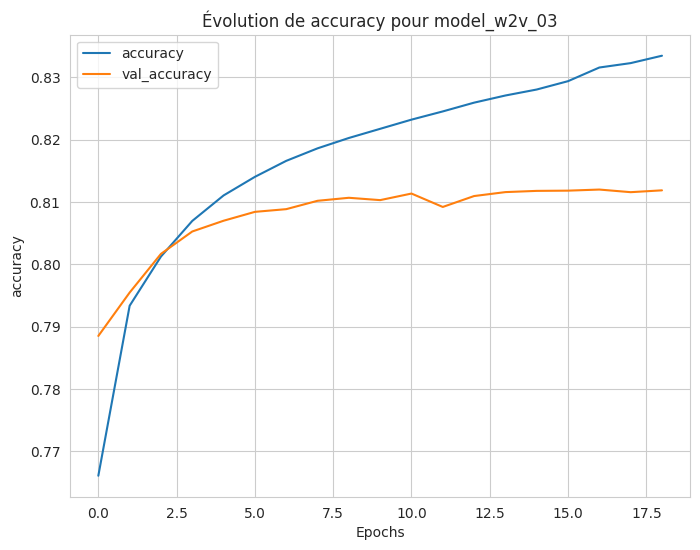

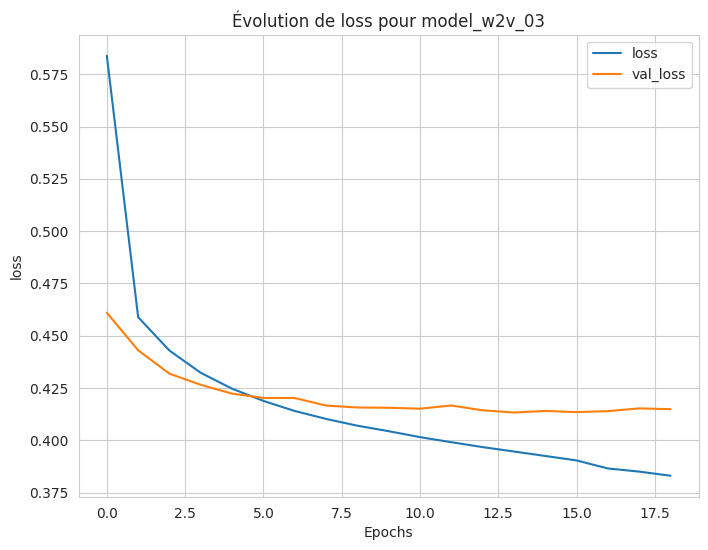

7500/7500 ━━━━━━━━━━━━━━━━━━━━ 49s 7ms/step


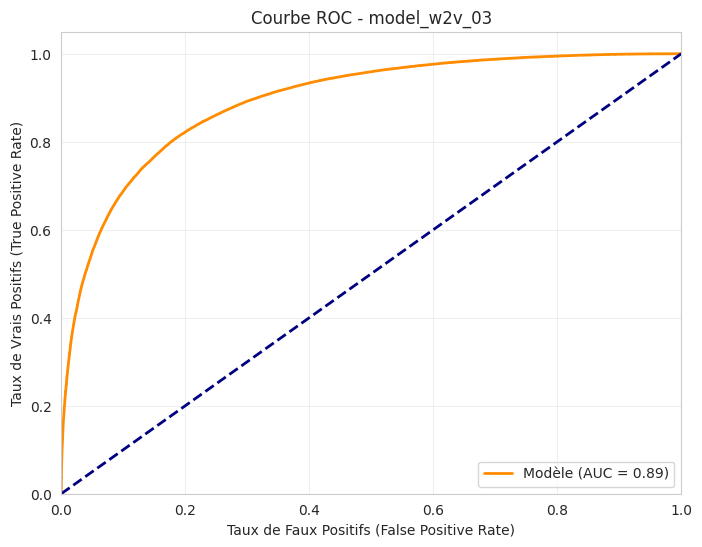

Fin de l'enregistrement MLflow pour model_w2v_03.


In [21]:
model_w2v_03_seq = Sequential([
    Input(shape=(MAX_LEN,)),
    Embedding(
        VOCAB_SIZE,
        EMBEDDING_DIM,
        weights=[embedding_matrix_w2v],
        trainable=True # Permet au modèle d'affiner encore un peu les vecteurs pour le sentiment
    ),
    Bidirectional(LSTM(32, return_sequences=False)),
    Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model_w2v_03_results_df = train_model(model_w2v_03_seq, EPOCHS, BATCH_SIZE, X_train_pad, y_train_lemmatized, X_val_pad, y_val_lemmatized, X_test_pad, y_test_lemmatized, learning_rate=0.0001, model_name="model_w2v_03")

model_w2v_03_results_df

In [ ]:
# TODO: Save les modèles avec un nom de repertoire (pas de keras ni de h5)